In [2]:
!which python

/Users/shenke/miniconda3/envs/pytorch_gpu/bin/python


In [27]:
# help(Box) 

In [8]:
import os
import copy
import random
import time
from operator import itemgetter
from collections import defaultdict, deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import gym
from gym.spaces import Box, Discrete
import matplotlib.pyplot as plt
from IPython import display

## params

In [9]:
board_width = 6        # 棋盘宽
board_height = 6       # 棋盘高
n_in_row = 4           # 胜利需要连成线棋子
c_puct = 5             # 决定探索程度
n_playout = 100        # 每步模拟次数
learn_rate = 0.002     # 学习率
lr_multiplier = 1.0    # 基于KL的自适应学习率调整
temperature = 1.0      # 温度参数
noise_eps = 0.75       # 噪声参数
dirichlet_alpha = 0.3  # dirichlet系数
buffer_size = 5000     # buffer大小
train_batch_size = 128 # batchsize大小
update_epochs = 5      # 多少个epoch更新一次
kl_coeff = 0.02        # kl系数
checkpoint_freq = 20   # 模型保存频率
mcts_infer = 200       # 纯mcts推理时间
restore_model = None   # 是否加载预训练模型
game_batch_num=40      # 训练步数
model_path="."         # 模型保存路径

## create environment

In [10]:
class GomokuEnv(gym.Env):
    def __init__(self, start_player=0):
        self.start_player = start_player

        self.action_space = Discrete((board_width * board_height))
        self.observation_space = Box(0, 1, shape=(4, board_width, board_height))
        self.reward = 0
        self.info = {}
        self.players = [1, 2]  # player1 and player2

    def step(self, action):
        self.states[action] = self.current_player
        if action in self.availables:
            self.availables.remove(action)

        self.last_move = action

        done, winner = self.game_end()
        reward = 0
        if done:
            if winner == self.current_player:
                reward = 1
            else:
                reward = -1

        self.current_player = (
            self.players[0] if self.current_player == self.players[1]
            else self.players[1]
        )

        # update state
        obs = self.current_state()

        return obs, reward, done, self.info

    def reset(self):
        if board_width < n_in_row or board_height < n_in_row:
            raise Exception('board width and height can not be '
                            'less than {}'.format(n_in_row))
        self.current_player = self.players[self.start_player]  # start player
        # keep available moves in a list
        self.availables = list(range(board_width * board_height))
        self.states = {}
        self.last_move = -1

        return self.current_state()

    def render(self, mode='human', start_player=0):
        width = board_width
        height = board_height

        p1, p2 = self.players

        print()
        for x in range(width):
            print("{0:8}".format(x), end='')
        print('\r\n')
        for i in range(height - 1, -1, -1):
            print("{0:4d}".format(i), end='')
            for j in range(width):
                loc = i * width + j
                p = self.states.get(loc, -1)
                if p == p1:
                    print('B'.center(8), end='')
                elif p == p2:
                    print('W'.center(8), end='')
                else:
                    print('_'.center(8), end='')
            print('\r\n\r\n')

    def has_a_winner(self):
        states = self.states
        moved = list(set(range(board_width * board_height)) - set(self.availables))
        if len(moved) < n_in_row * 2 - 1:
            return False, -1

        for m in moved:
            h = m // board_width
            w = m % board_width
            player = states[m]

            if (w in range(board_width - n_in_row + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n_in_row))) == 1):
                return True, player

            if (h in range(board_height - n_in_row + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n_in_row * board_width, board_width))) == 1):
                return True, player

            if (w in range(board_width - n_in_row + 1) and h in range(board_height - n_in_row + 1) and
                    len(set(
                        states.get(i, -1) for i in range(m, m + n_in_row * (board_width + 1), board_width + 1))) == 1):
                return True, player

            if (w in range(n_in_row - 1, board_width) and h in range(board_height - n_in_row + 1) and
                    len(set(
                        states.get(i, -1) for i in range(m, m + n_in_row * (board_width - 1), board_width - 1))) == 1):
                return True, player

        return False, -1

    def game_end(self):
        """Check whether the game is ended or not"""
        win, winner = self.has_a_winner()
        if win:
            # print("winner is player{}".format(winner))
            return True, winner
        elif not len(self.availables):
            return True, -1
        return False, -1

    def current_state(self):
        """return the board state from the perspective of the current player.
        state shape: 4*width*height
        """
        square_state = np.zeros((4, board_width, board_height))
        if self.states:
            moves, players = np.array(list(zip(*self.states.items())))
            move_curr = moves[players == self.current_player]
            move_oppo = moves[players != self.current_player]
            square_state[0][move_curr // board_width,
                            move_curr % board_height] = 1.0
            square_state[1][move_oppo // board_width,
                            move_oppo % board_height] = 1.0
            # indicate the last move location
            square_state[2][self.last_move // board_width,
                            self.last_move % board_height] = 1.0
        if len(self.states) % 2 == 0:
            square_state[3][:, :] = 1.0  # indicate the colour to play
        return square_state[:, ::-1, :]

    def start_play(self, player1, player2, start_player=0):
        """start a game between two players"""
        if start_player not in (0, 1):
            raise Exception('start_player should be either 0 (player1 first) '
                            'or 1 (player2 first)')
        self.reset()
        p1, p2 = self.players
        player1.set_player_ind(p1)
        player2.set_player_ind(p2)
        players = {p1: player1, p2: player2}
        while True:
            player_in_turn = players[self.current_player]
            move = player_in_turn.get_action(self)
            self.step(move)
            end, winner = self.game_end()
            if end:
                return winner

    def start_self_play(self, player):
        """ start a self-play game using a MCTS player, reuse the search tree,
        and store the self-play data: (state, mcts_probs, z) for training
        """
        self.reset()
        states, mcts_probs, current_players = [], [], []
        while True:
            move, move_probs = player.get_action(self, return_prob=1)
            # store the data
            states.append(self.current_state())
            mcts_probs.append(move_probs)
            current_players.append(self.current_player)
            # perform a move
            self.step(move)
            end, winner = self.game_end()
            if end:
                # winner from the perspective of the current player of each state
                winners_z = np.zeros(len(current_players))
                if winner != -1:
                    winners_z[np.array(current_players) == winner] = 1.0
                    winners_z[np.array(current_players) != winner] = -1.0
                # reset MCTS root node
                player.reset_player()
                return winner, zip(states, mcts_probs, winners_z)
            
    def location_to_move(self, location):
        if (len(location) != 2):
            return -1
        h = location[0]
        w = location[1]
        move = h * board_width + w
        if (move not in range(board_width * board_width)):
            return -1
        return move

    def move_to_location(self, move):
        """
        3*3 board's moves like:
        6 7 8
        3 4 5
        0 1 2
        and move 5's location is (1,2)
        """
        h = move // board_width
        w = move % board_width
        return [h, w]

## create net

In [16]:
class Net(nn.Module):
    """policy-value network module"""

    def __init__(self):
        super(Net, self).__init__()

        # common layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # action policy layers
        self.act_conv1 = nn.Conv2d(128, 4, kernel_size=1)
        self.act_fc1 = nn.Linear(4 * board_width * board_height,
                                 board_width * board_height)
        # state value layers
        self.val_conv1 = nn.Conv2d(128, 2, kernel_size=1)
        self.val_fc1 = nn.Linear(2 * board_width * board_height, 64)
        self.val_fc2 = nn.Linear(64, 1)

    def forward(self, state_input):
        # common layers
        x = F.relu(self.conv1(state_input))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # action policy layers
        x_act = F.relu(self.act_conv1(x))
        x_act = x_act.view(-1, 4 * board_width * board_height)
        x_act = F.log_softmax(self.act_fc1(x_act))
        # state value layers
        x_val = F.relu(self.val_conv1(x))
        x_val = x_val.view(-1, 2 * board_width * board_height)
        x_val = F.relu(self.val_fc1(x_val))
        x_val = F.tanh(self.val_fc2(x_val))

        return x_act, x_val


class PolicyValueNet:
    """policy-value network """

    def __init__(self, model_file=None):

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        self.l2_const = 1e-4  # coef of l2 penalty
        # the policy value net module

        self.policy_value_net = Net().to(self.device)
        self.optimizer = optim.Adam(self.policy_value_net.parameters(),
                                    weight_decay=self.l2_const)

        if model_file:
            net_params = torch.load(model_file)
            self.policy_value_net.load_state_dict(net_params)

    def policy_value(self, state_batch):
        """
        input: a batch of states
        output: a batch of action probabilities and state values
        """
        state_batch = Variable(torch.FloatTensor(state_batch).to(self.device))
        log_act_probs, value = self.policy_value_net(state_batch)
        act_probs = np.exp(log_act_probs.data.cpu().numpy())
        return act_probs, value.data.cpu().numpy()

    def policy_value_fn(self, board):
        """
        input: board
        output: a list of (action, probability) tuples for each available
        action and the score of the board state
        """
        legal_positions = board.availables
        current_state = np.ascontiguousarray(board.current_state().reshape(
            -1, 4, board_width, board_height))
        log_act_probs, value = self.policy_value_net(
            Variable(torch.from_numpy(current_state)).to(self.device).float())
        act_probs = np.exp(log_act_probs.data.cpu().numpy().flatten())
        act_probs = zip(legal_positions, act_probs[legal_positions])
        value = value.data[0][0]
        return act_probs, value

    def train_step(self, state_batch, mcts_probs, winner_batch, lr):
        """perform a training step"""
        # wrap in Variable
        state_batch = Variable(torch.FloatTensor(state_batch).to(self.device))
        mcts_probs = Variable(torch.FloatTensor(mcts_probs).to(self.device))
        winner_batch = Variable(torch.FloatTensor(winner_batch).to(self.device))

        # zero the parameter gradients
        self.optimizer.zero_grad()
        # set learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        # forward
        log_act_probs, value = self.policy_value_net(state_batch)
        # define the loss = (z - v)^2 - pi^T * log(p) + c||theta||^2
        # Note: the L2 penalty is incorporated in optimizer
        value_loss = F.mse_loss(value.view(-1), winner_batch)
        policy_loss = -torch.mean(torch.sum(mcts_probs * log_act_probs, 1))
        loss = value_loss + policy_loss
        # backward and optimize
        loss.backward()
        self.optimizer.step()
        # calc policy entropy, for monitoring only
        entropy = -torch.mean(
            torch.sum(torch.exp(log_act_probs) * log_act_probs, 1)
        )
        # return loss.data, entropy.data
        # for pytorch version >= 0.5 please use the following line instead.
        return loss.item(), entropy.item()

    def get_policy_param(self):
        net_params = self.policy_value_net.state_dict()
        return net_params

    def save_model(self, model_file):
        """ save model params to file """
        net_params = self.get_policy_param()  # get model params
        torch.save(net_params, model_file)

## implement MCTS

In [17]:
def softmax(x):
    probs = np.exp(x - np.max(x))
    probs /= np.sum(probs)
    return probs


def rollout_policy_fn(board):
    """a coarse, fast version of policy_fn used in the rollout phase."""
    # rollout randomly
    action_probs = np.random.rand(len(board.availables))
    return zip(board.availables, action_probs)


def policy_value_fn(board):
    """a function that takes in a state and outputs a list of (action, probability)
    tuples and a score for the state"""
    # return uniform probabilities and 0 score for pure MCTS
    action_probs = np.ones(len(board.availables)) / len(board.availables)
    return zip(board.availables, action_probs), 0


class TreeNode:
    """A node in the MCTS tree.

    Each node keeps track of its own value Q, prior probability P, and
    its visit-count-adjusted prior score u.
    """

    def __init__(self, parent, prior_p):
        self._parent = parent
        self._children = {}  # a map from action to TreeNode
        self._n_visits = 0
        self._Q = 0
        self._u = 0
        self._P = prior_p

    def expand(self, action_priors):
        """Expand tree by creating new children.
        action_priors: a list of tuples of actions and their prior probability
            according to the policy function.
        """
        for action, prob in action_priors:
            if action not in self._children:
                self._children[action] = TreeNode(self, prob)

    def select(self, c_puct):
        """Select action among children that gives maximum action value Q
        plus bonus u(P).
        Return: A tuple of (action, next_node)
        """
        return max(self._children.items(),
                   key=lambda act_node: act_node[1].get_value(c_puct))

    def update(self, leaf_value):
        """Update node values from leaf evaluation.
        leaf_value: the value of subtree evaluation from the current player's
            perspective.
        """
        # Count visit.
        self._n_visits += 1
        # Update Q, a running average of values for all visits.
        self._Q += 1.0 * (leaf_value - self._Q) / self._n_visits

    def update_recursive(self, leaf_value):
        """Like a call to update(), but applied recursively for all ancestors.
        """
        # If it is not root, this node's parent should be updated first.
        if self._parent:
            self._parent.update_recursive(-leaf_value)
        self.update(leaf_value)

    def get_value(self, c_puct):
        """Calculate and return the value for this node.
        It is a combination of leaf evaluations Q, and this node's prior
        adjusted for its visit count, u.
        c_puct: a number in (0, inf) controlling the relative impact of
            value Q, and prior probability P, on this node's score.
        """
        self._u = (c_puct * self._P *
                   np.sqrt(self._parent._n_visits) / (1 + self._n_visits))
        return self._Q + self._u

    def is_leaf(self):
        """Check if leaf node (i.e. no nodes below this have been expanded)."""
        return self._children == {}

    def is_root(self):
        return self._parent is None


class MCTS:
    """An implementation of Monte Carlo Tree Search."""

    def __init__(self, policy_value_fn, c_puct=5):
        """
        policy_value_fn: a function that takes in a board state and outputs
            a list of (action, probability) tuples and also a score in [-1, 1]
            (i.e. the expected value of the end game score from the current
            player's perspective) for the current player.
        c_puct: a number in (0, inf) that controls how quickly exploration
            converges to the maximum-value policy. A higher value means
            relying on the prior more.
        """
        self._root = TreeNode(None, 1.0)
        self._policy = policy_value_fn
        self._c_puct = c_puct

    def _playout(self, state):
        """Run a single playout from the root to the leaf, getting a value at
        the leaf and propagating it back through its parents.
        State is modified in-place, so a copy must be provided.
        """
        node = self._root
        while (1):
            if node.is_leaf():
                break
            # Greedily select next move.
            action, node = node.select(self._c_puct)
            state.step(action)

        # Evaluate the leaf using a network which outputs a list of
        # (action, probability) tuples p and also a score v in [-1, 1]
        # for the current player.
        action_probs, leaf_value = self._policy(state)
        # Check for end of game.
        end, winner = state.game_end()
        if not end:
            node.expand(action_probs)
        else:
            # for end state, return the true leaf_value
            if winner == -1:  # tie
                leaf_value = 0.0
            else:
                leaf_value = (
                    1.0 if winner == state.current_player else -1.0
                )

        # Update value and visit count of nodes in this traversal.
        node.update_recursive(-leaf_value)

    def _playout_p(self, state):
        """Run a single playout from the root to the leaf, getting a value at
        the leaf and propagating it back through its parents.
        State is modified in-place, so a copy must be provided.
        """
        node = self._root
        while (1):
            if node.is_leaf():
                break
            # Greedily select next move.
            action, node = node.select(self._c_puct)
            state.step(action)

        action_probs, _ = self._policy(state)
        # Check for end of game
        end, winner = state.game_end()
        if not end:
            node.expand(action_probs)
        # Evaluate the leaf node by random rollout
        leaf_value = self._evaluate_rollout(state)
        # Update value and visit count of nodes in this traversal.
        node.update_recursive(-leaf_value)

    def _evaluate_rollout(self, env, limit=1000):
        """Use the rollout policy to play until the end of the game,
        returning +1 if the current player wins, -1 if the opponent wins,
        and 0 if it is a tie.
        """
        player = env.current_player
        for i in range(limit):
            end, winner = env.game_end()
            if end:
                break
            action_probs = rollout_policy_fn(env)
            max_action = max(action_probs, key=itemgetter(1))[0]
            env.step(max_action)
        else:
            # If no break from the loop, issue a warning.
            print("WARNING: rollout reached move limit")
        if winner == -1:  # tie
            return 0
        else:
            return 1 if winner == player else -1

    def get_move_probs(self, state, temp=1e-3):
        """Run all playouts sequentially and return the available actions and
        their corresponding probabilities.
        state: the current game state
        temp: temperature parameter in (0, 1] controls the level of exploration
        """
        for n in range(n_playout):
            state_copy = copy.deepcopy(state)
            self._playout(state_copy)

        # calc the move probabilities based on visit counts at the root node
        act_visits = [(act, node._n_visits)
                      for act, node in self._root._children.items()]
        acts, visits = zip(*act_visits)
        act_probs = softmax(1.0 / temp * np.log(np.array(visits) + 1e-10))

        return acts, act_probs

    def get_move(self, state):
        """Runs all playouts sequentially and returns the most visited action.
        state: the current game state

        Return: the selected action
        """
        for n in range(n_playout):
            state_copy = copy.deepcopy(state)
            self._playout_p(state_copy)
        return max(self._root._children.items(),
                   key=lambda act_node: act_node[1]._n_visits)[0]

    def update_with_move(self, last_move):
        """Step forward in the tree, keeping everything we already know
        about the subtree.
        """
        if last_move in self._root._children:
            self._root = self._root._children[last_move]
            self._root._parent = None
        else:
            self._root = TreeNode(None, 1.0)

    def __str__(self):
        return "MCTS"

## self-play

In [13]:
class MCTS_Pure:
    """AI player based on MCTS"""

    def __init__(self):
        self.mcts = MCTS(policy_value_fn, c_puct)

    def set_player_ind(self, p):
        self.player = p

    def reset_player(self):
        self.mcts.update_with_move(-1)

    def get_action(self, board):
        sensible_moves = board.availables
        if len(sensible_moves) > 0:
            move = self.mcts.get_move(board)
            self.mcts.update_with_move(-1)
            return move
        else:
            print("WARNING: the board is full")

    def __str__(self):
        return "MCTS {}".format(self.player)


class MCTSPlayer(MCTS_Pure):
    """AI player based on MCTS"""

    def __init__(self, policy_value_function, is_selfplay=0):
        super(MCTS_Pure, self).__init__()
        self.mcts = MCTS(policy_value_function, c_puct)
        self._is_selfplay = is_selfplay

    def get_action(self, env, return_prob=0):
        sensible_moves = env.availables
        # the pi vector returned by MCTS as in the alphaGo Zero paper
        move_probs = np.zeros(board_width * board_width)
        if len(sensible_moves) > 0:
            acts, probs = self.mcts.get_move_probs(env, temperature)
            move_probs[list(acts)] = probs
            if self._is_selfplay:
                # add Dirichlet Noise for exploration (needed for
                # self-play training)
                move = np.random.choice(
                    acts,
                    p=noise_eps * probs + (1 - noise_eps) * np.random.dirichlet(
                        dirichlet_alpha * np.ones(len(probs))))
                # update the root node and reuse the search tree
                self.mcts.update_with_move(move)
            else:
                # with the default temp=1e-3, it is almost equivalent
                # to choosing the move with the highest prob
                move = np.random.choice(acts, p=probs)
                # reset the root node
                self.mcts.update_with_move(-1)

            if return_prob:
                return move, move_probs
            else:
                return move
        else:
            print("WARNING: the board is full")

## train main function

In [18]:
class TrainPipeline:
    def __init__(self):
        # params of the board and the game
        self.env = GomokuEnv()

        # training params
        self.data_buffer = deque(maxlen=buffer_size)
        self.play_batch_size = 1
        self.best_win_ratio = 0.0

        # start training from an initial policy-value net
        self.policy_value_net = PolicyValueNet(model_file=restore_model)

        self.mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn,
                                      is_selfplay=1)
        self.mcts_infer = mcts_infer
        self.lr_multiplier = lr_multiplier

    def get_equi_data(self, play_data):
        """augment the data set by rotation and flipping
        play_data: [(state, mcts_prob, winner_z), ..., ...]
        """
        extend_data = []
        for state, mcts_porb, winner in play_data:
            for i in [1, 2, 3, 4]:
                # rotate counterclockwise
                equi_state = np.array([np.rot90(s, i) for s in state])
                equi_mcts_prob = np.rot90(np.flipud(
                    mcts_porb.reshape(board_height, board_width)), i)
                extend_data.append((equi_state,
                                    np.flipud(equi_mcts_prob).flatten(),
                                    winner))
                # flip horizontally
                equi_state = np.array([np.fliplr(s) for s in equi_state])
                equi_mcts_prob = np.fliplr(equi_mcts_prob)
                extend_data.append((equi_state,
                                    np.flipud(equi_mcts_prob).flatten(),
                                    winner))
        return extend_data

    def collect_selfplay_data(self, n_games=1):
        """collect self-play data for training"""
        for i in range(n_games):
            winner, play_data = self.env.start_self_play(self.mcts_player)
            play_data = list(play_data)[:]
            self.episode_len = len(play_data)
            # augment the data
            play_data = self.get_equi_data(play_data)
            self.data_buffer.extend(play_data)

    def policy_update(self):
        """update the policy-value net"""
        mini_batch = random.sample(self.data_buffer, train_batch_size)
        state_batch = [data[0] for data in mini_batch]
        mcts_probs_batch = [data[1] for data in mini_batch]
        winner_batch = [data[2] for data in mini_batch]
        old_probs, old_v = self.policy_value_net.policy_value(state_batch)
        for i in range(update_epochs):
            loss, entropy = self.policy_value_net.train_step(
                state_batch,
                mcts_probs_batch,
                winner_batch,
                learn_rate * self.lr_multiplier)
            new_probs, new_v = self.policy_value_net.policy_value(state_batch)
            kl = np.mean(np.sum(old_probs * (
                    np.log(old_probs + 1e-10) - np.log(new_probs + 1e-10)),
                                axis=1)
                         )
            if kl > kl_coeff * 4:  # early stopping if D_KL diverges badly
                break
        # adaptively adjust the learning rate
        if kl > kl_coeff * 2 and self.lr_multiplier > 0.1:
            self.lr_multiplier /= 1.5
        elif kl < kl_coeff / 2 and self.lr_multiplier < 10:
            self.lr_multiplier *= 1.5
        return loss, entropy

    def policy_evaluate(self, n_games=10):
        """
        Evaluate the trained policy by playing against the pure MCTS player
        Note: this is only for monitoring the progress of training
        """
        current_mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn)
        pure_mcts_player = MCTS_Pure()
        win_cnt = defaultdict(int)
        for i in range(n_games):
            winner = self.env.start_play(current_mcts_player,
                                         pure_mcts_player,
                                         start_player=i % 2)
            win_cnt[winner] += 1
        win_ratio = 1.0 * (win_cnt[1] + 0.5 * win_cnt[-1]) / n_games
        print("num_playouts:{}, win: {}, lose: {}, tie:{}".format(self.mcts_infer,
                                                                  win_cnt[1], win_cnt[2], win_cnt[-1]))
        return win_ratio

    def run(self):
        """run the training pipeline"""
        win_num = 0
        try:
            for i_step in range(game_batch_num):
                self.collect_selfplay_data(self.play_batch_size)
                print("batch i:{}, episode_len:{}".format(
                    i_step + 1, self.episode_len))
                if len(self.data_buffer) > train_batch_size:
                    loss, entropy = self.policy_update()
                # check the performance of the current model,
                # and save the model params
                if (i_step + 1) % checkpoint_freq == 0:
                    print("current self-play batch: {}".format(i_step + 1))
                    win_ratio = self.policy_evaluate()
                    self.policy_value_net.save_model(os.path.join(model_path, "newest_model.pt"))
                    if win_ratio > self.best_win_ratio:
                        win_num += 1
                        # print("New best policy!!!!!!!!")
                        self.best_win_ratio = win_ratio
                        # update the best_policy
                        self.policy_value_net.save_model(os.path.join(model_path, "best_model.pt"))
                        if self.best_win_ratio == 1.0 and self.mcts_infer < 5000:
                            self.mcts_infer += 1000
                            self.best_win_ratio = 0.0
        except KeyboardInterrupt:
            print('\n\rquit')

        return win_num



## self-play train and save model

In [19]:
start_t = time.time()
training_pipeline = TrainPipeline()
training_pipeline.run()
print("time cost is {}".format(time.time()-start_t))

/var/folders/4v/_ggyyph946s3tv60n6fng92w0000gn/T/ipykernel_731/3097606431.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_act = F.log_softmax(self.act_fc1(x_act))
/Users/shenke/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


batch i:1, episode_len:18


/var/folders/4v/_ggyyph946s3tv60n6fng92w0000gn/T/ipykernel_731/3097606431.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076272873/work/torch/csrc/utils/tensor_new.cpp:233.)
  state_batch = Variable(torch.FloatTensor(state_batch).to(self.device))


batch i:2, episode_len:10
batch i:3, episode_len:14
batch i:4, episode_len:12
batch i:5, episode_len:14
batch i:6, episode_len:10
batch i:7, episode_len:12
batch i:8, episode_len:12
batch i:9, episode_len:23
batch i:10, episode_len:15
batch i:11, episode_len:13
batch i:12, episode_len:14
batch i:13, episode_len:12
batch i:14, episode_len:14
batch i:15, episode_len:12
batch i:16, episode_len:23
batch i:17, episode_len:14
batch i:18, episode_len:17
batch i:19, episode_len:14
batch i:20, episode_len:14
current self-play batch: 20
num_playouts:200, win: 2, lose: 8, tie:0
batch i:21, episode_len:20
batch i:22, episode_len:22
batch i:23, episode_len:15
batch i:24, episode_len:9
batch i:25, episode_len:19
batch i:26, episode_len:13
batch i:27, episode_len:10
batch i:28, episode_len:21
batch i:29, episode_len:18
batch i:30, episode_len:19
batch i:31, episode_len:17
batch i:32, episode_len:19
batch i:33, episode_len:13
batch i:34, episode_len:17
batch i:35, episode_len:15
batch i:36, episode_le

# AI battle

In [21]:
# 定义当前玩家
class CurPlayer:
    player_id = 0


# 可视化部分
class Game(object):
    def __init__(self, board):
        self.board = board
        self.cell_size = board_width - 1
        self.chess_size = 50 * self.cell_size

        self.whitex = []
        self.whitey = []
        self.blackx = []
        self.blacky = []

        # 棋盘背景色
        self.color = "#e4ce9f"
        self.colors = [[self.color] * self.cell_size for _ in range(self.cell_size)]

    def graphic(self, board, player1, player2):
        """Draw the board and show game info"""
        plt_fig, ax = plt.subplots(facecolor=self.color)
        ax.set_facecolor(self.color)

        # 制作棋盘
        # mytable = ax.table(cellColours=self.colors, loc='center')
        mytable = plt.table(cellColours=self.colors,
                            colWidths=[1 / board_width] * self.cell_size,
                            loc='center'
                            )

        ax.set_aspect('equal')

        # 网格大小
        cell_height = 1 / board_width
        for pos, cell in mytable.get_celld().items():
            cell.set_height(cell_height)

        mytable.auto_set_font_size(False)
        mytable.set_fontsize(self.cell_size)
        ax.set_xlim([1, board_width * 2 + 1])
        ax.set_ylim([board_height * 2 + 1, 1])
        plt.title("Gomoku")

        plt.axis('off')
        cur_player = CurPlayer()

        while True:
            # left down of mouse
            try:
                if cur_player.player_id == 1:
                    move = player1.get_action(self.board)
                    self.board.step(move)
                    x, y = self.board.move_to_location(move)
                    plt.scatter((y + 1) * 2, (x + 1) * 2, s=self.chess_size, c='white')
                    cur_player.player_id = 0
                elif cur_player.player_id == 0:
                    move = player2.get_action(self.board)
                    self.board.step(move)
                    x, y = self.board.move_to_location(move)
                    plt.scatter((y + 1) * 2, (x + 1) * 2, s=self.chess_size, c='black')
                    cur_player.player_id = 1

                end, winner = self.board.game_end()
                if end:
                    if winner != -1:
                        ax.text(x=board_width, y=(board_height + 1) * 2 + 0.1,
                                s="Game end. Winner is player {}".format(cur_player.player_id), fontsize=10,
                                color='red', weight='bold',
                                horizontalalignment='center')
                    else:
                        ax.text(x=board_width, y=(board_height + 1) * 2 + 0.1,
                                s="Game end. Tie Round".format(cur_player.player_id), fontsize=10, color='red',
                                weight='bold',
                                horizontalalignment='center')                   
                    return winner
                display.display(plt.gcf())
                display.clear_output(wait=True)
            except:
                pass

    def start_play(self, player1, player2, start_player=0):
        """start a game between two players"""
        if start_player not in (0, 1):
            raise Exception('start_player should be either 0 (player1 first) '
                            'or 1 (player2 first)')
        self.board.reset()
        p1, p2 = self.board.players
        player1.set_player_ind(p1)
        player2.set_player_ind(p2)

        self.graphic(self.board, player1, player2)

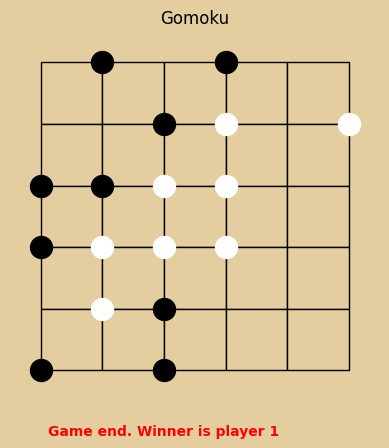

In [25]:
# 初始化棋盘
board = GomokuEnv()
game = Game(board)
# 加载模型
best_policy = PolicyValueNet(model_file="best_model.pt")
# 两个AI对打
mcts_player = MCTSPlayer(best_policy.policy_value_fn)
# 开始对打
game.start_play(mcts_player, mcts_player, start_player=0)